<a href="https://colab.research.google.com/github/DrumDong/Donggyu/blob/master/Car_MPG_Prediction_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib
import numpy as np

import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.15.0


# 데이터 가져오기

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


데이터셋 정보

- mpg: 갤런 당 …마일(miles per gallon: 차량의 연료 소비 정도를 나타내는 표현) 
- Cylinders: (엔진의) 실린더
- Displacement: 배수량
- Horsepower: 마력
- Weight	: 무게
- Acceleration: 차량의 가속도
- Model Year: 모델 출시 연도
- Origin: 차종

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

## 결측치 처리

In [6]:
'''
dataset = dataset.dropna()
dataset.isna().sum() 
#이 방법은 사용하지 않겠음
'''

'\ndataset = dataset.dropna()\ndataset.isna().sum() \n#이 방법은 사용하지 않겠음\n'

결측치 처리 중에 대표적인 방법이 결측치가 들어있는 행을 그냥 삭제해 버리는 것이다. 하지만 데이터의 양이 중요한 시점에서 이렇게 행을 삭제하는 것은 바람직하다고 생각을 하지 않아서 다른 방법을 쓰기로 했다.

---

Horespower와 상관관계가 높은 변수(여기서는 실린더)를 통하여, 각 실린더마다의 Horsepower의 평균 또는 중앙값을 구하여 Null값이 포함된 곳에 삽입해주기로 헀다.

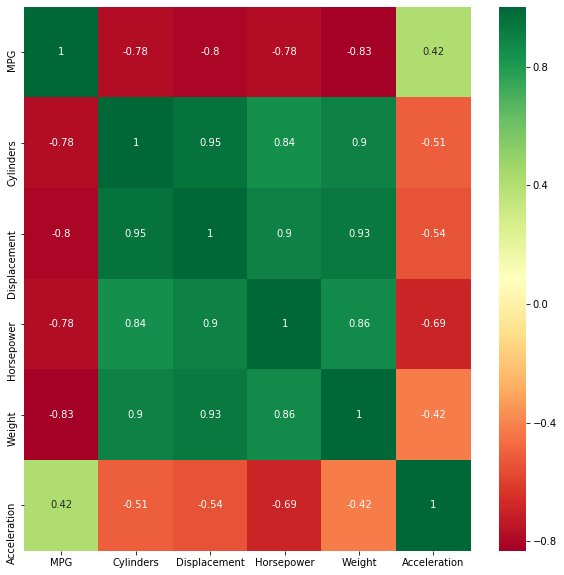

In [7]:
# Horse와 상관관계가 높은 feature만 뽑아보자.
corrmat = dataset.corr()
top_corr_features = corrmat.index[abs(corrmat["Horsepower"])>0.5]
plt.figure(figsize=(10,10),facecolor='w')
g = sns.heatmap(dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

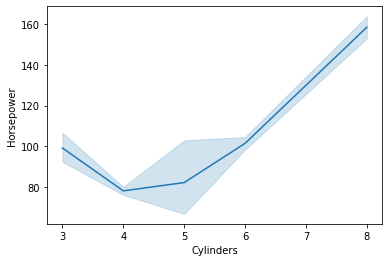

In [8]:
sns.lineplot(dataset['Cylinders'],dataset['Horsepower'])

In [9]:
dataset[dataset['Horsepower'].isna()]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
32,25.0,4,98.0,NaN,2046.0,19.0,71,1
126,21.0,6,200.0,NaN,2875.0,17.0,74,1
330,40.9,4,85.0,NaN,1835.0,17.3,80,2
336,23.6,4,140.0,NaN,2905.0,14.3,80,1
354,34.5,4,100.0,NaN,2320.0,15.8,81,2
374,23.0,4,151.0,NaN,3035.0,20.5,82,1


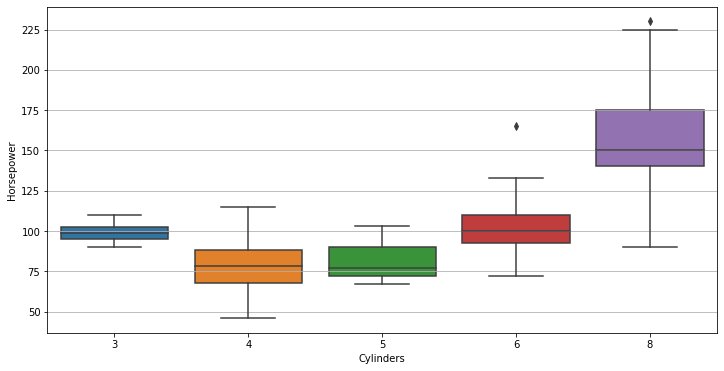

In [10]:
plt.figure(figsize=(12,6),facecolor='w')
plt.grid(True)

sns.boxplot(x='Cylinders',y='Horsepower',data=dataset)
plt.show()

In [11]:
dataset['Horsepower'].groupby(dataset['Cylinders']).mean()

Cylinders
3     99.250000
4     78.281407
5     82.333333
6    101.506024
8    158.300971
Name: Horsepower, dtype: float64

In [0]:
dataset['Horsepower'].fillna(dataset.groupby('Cylinders')['Horsepower'].transform('median'),inplace=True)

In [13]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

# Origin
- 원핫 인코딩을 통한 변수 정리
- 원핫 인코딩을 하는 이유는 컴퓨터는 결국 숫자의 차이를 해석하기 떄문이다. Origin 변수는 0,1,2로 변수가 지정되어 있는데 이것은 사실상 순서를 의미하는 것이 아니기 때문이다. 
- 튜토리얼에 나와있는 것 처럼 이 데이터는 made in Japn , Europe, USA를 뜻하는 것이지 어떠한 순서가 있는 것은 아니다. 그렇기 때문에 이것을 더비변수화를 시켜서 컴퓨터가 잘 해석할 수 있게 만드는 과정이 바로 원핫 인코딩이다.
- 다만 원한인코딩을 할 때 주의해야 할 점은 변수들이 증가하기 때문에 컴퓨터가 해석해야할 양이 많아진다. 여기서는 크게 상관 없지만 컬럼이 정말 많은 데이터에서는 이 부분을 정말 조심해야하는 것을 잊지 않는 것이 중요하다.

In [14]:
dataset['Origin'].value_counts()

1    249
3     79
2     70
Name: Origin, dtype: int64

In [15]:
dataset['USA'] = (dataset['Origin'] == 1)*1.0
dataset['Europe'] = (dataset['Origin'] == 2)*1.0
dataset['Japan'] = (dataset['Origin'] == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,1.0,0.0,0.0


In [16]:
dataset.pop('Origin')

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 398, dtype: int64

In [17]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


# data split
- train 셋과 test 셋으로 나눠보자.

In [18]:
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(dataset, test_size=0.3, random_state=0)
train_data.shape, test_data.shape

((278, 10), (120, 10))

In [0]:
X_train=train_data.iloc[:,1:]
y_train=train_data.iloc[:,0]
X_test=test_data.iloc[:,1:]
y_test=test_data.iloc[:,0]

In [20]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(278, 9) (278,)
(120, 9) (120,)


# Modeling

In [21]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [22]:
model =Sequential()
model.add(Dense(30,input_dim=9,activation='relu'))
model.add(Dense(6,activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer='adam')
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 186       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 493
Trainable params: 493
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 모델 최적화 설정
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
import os

MODEL_DIR ='./model/'
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

modelpath='./model/{epoch:02d}-{val_loss:4f}.hdf5'

checkpointer= ModelCheckpoint(filepath=modelpath,monitor='val_loss',verbose=1,save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10)

모델 최적화를 설정하는 이유는 과적합을 피하기 위해서이다. train에만 너무 학습되면 새로운 데이터를 제대로 분류 또는 예츧을 할 수 없게 된다. 그래서 그것을 방지하기 위해 keras의 Early stop을 사용해서 val_loss가 더이상 감소가 되지 않으면 학습을 중지시키게 만들었다. 10번 이상 줄어 들지 않으면 학습을 중지하고 그것을 바탕으로한 최적의 모델을 사용하여 학습을 하기로 함.

In [27]:
hist= model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10000,verbose=0,
                callbacks=[early_stopping_callback,checkpointer])










Epoch 00001: val_loss improved from inf to 652032.52917, saving model to ./model/01-652032.529167.hdf5

Epoch 00002: val_loss improved from 652032.52917 to 329958.18750, saving model to ./model/02-329958.187500.hdf5

Epoch 00003: val_loss improved from 329958.18750 to 179740.93229, saving model to ./model/03-179740.932292.hdf5

Epoch 00004: val_loss improved from 179740.93229 to 93283.84427, saving model to ./model/04-93283.844271.hdf5

Epoch 00005: val_loss improved from 93283.84427 to 43669.80208, saving model to ./model/05-43669.802083.hdf5

Epoch 00006: val_loss improved from 43669.80208 to 17855.22448, saving model to ./model/06-17855.224479.hdf5

Epoch 00007: val_loss improved from 17855.22448 to 6262.72982, saving model to ./model/07-6262.729818.hdf5

Epoch 00008: val_loss improved from 6262.72982 to 2074.86821, saving model to ./model/08-2074.868213.hdf5

Epoch 00009: val_loss improved from 2074.86821 to 993.55251, saving model to ./model/09-993.552507.hdf5

Epoch 0001

In [0]:
#테스트셋(검증셋) 오차
y_vloss= hist.history['val_loss']
#트레인셋 오차
y_loss= hist.history['loss']

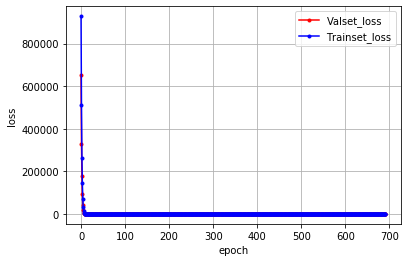

In [32]:
#그래프 표현
x_len = np.arange(len(y_loss))

fig = plt.figure()
fig.patch.set_facecolor('w')

plt.plot(x_len,y_vloss,marker='.',c='red',label='Valset_loss')
plt.plot(x_len,y_loss,marker='.',c='blue',label='Trainset_loss')

#그래프에 그리드, 레이블 삽입

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

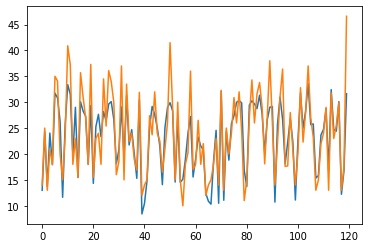

In [37]:
Y_test_pred = model.predict(X_test,verbose=0)

x_line=[]
for i in range(len(Y_test_pred)):
  x_line.append(i)

plt.plot(x_line,Y_test_pred)
plt.plot(x_line,y_test)
plt.show()

결과적으로 학습 횟수를 많이 하지 않아도 모델 자체(DNN)에서 적당한 개수의 은닉층들의 학습을 잘 하게 만든 것으로 보인다. 또한 밑의 그래프를 확인해보면 예측해서 만든 결과와 원래의 결과가 크게 차이가 없는 것으로 보아 학습이 제대로 된것으로 판단된다.